## BCM rule

Let's start by importing necassay packages and importing `get_BCM` function from the bpmodels package.

In [1]:
import brainpy as bp
import numpy as np
import matplotlib.pyplot as plt
from bpmodels.learning_rules import get_BCM

bp.profile.set(dt=.1)

Since the BCM rule is based on rate models, we will first define a simple rate neuron with `NeuState` r (the firing rate).

In [2]:
def rate_neuron():
    ST = bp.types.NeuState(['r', 'input'])

    def g(r, I):
        r += I
        return r

    def update(ST):
        ST['r'] = g(ST['r'], ST['input'])
    
    def reset(ST):
        ST['input'] = 0.

    return bp.NeuType(name='rate', steps=[update, reset], ST=ST, mode='vector')

### Group discrimination

We simulate a situation that one neuron receives 20 inputs. The inputs are organized into two groups of 10 inputs, and the two groups fire in alternation: when group 1 is active, group 2 is silent. The inputs switches between the two groups every second.

Here we set the initial weights as $w_{ij} = 1$, and the maximum weights as $2$.

Given that group 1 fires at 1.5 Hz, then group 2 at 1 Hz, we will expect to see that the synapses of the first population of neurons become stronger with time, while the weights of group 2 become weaker.

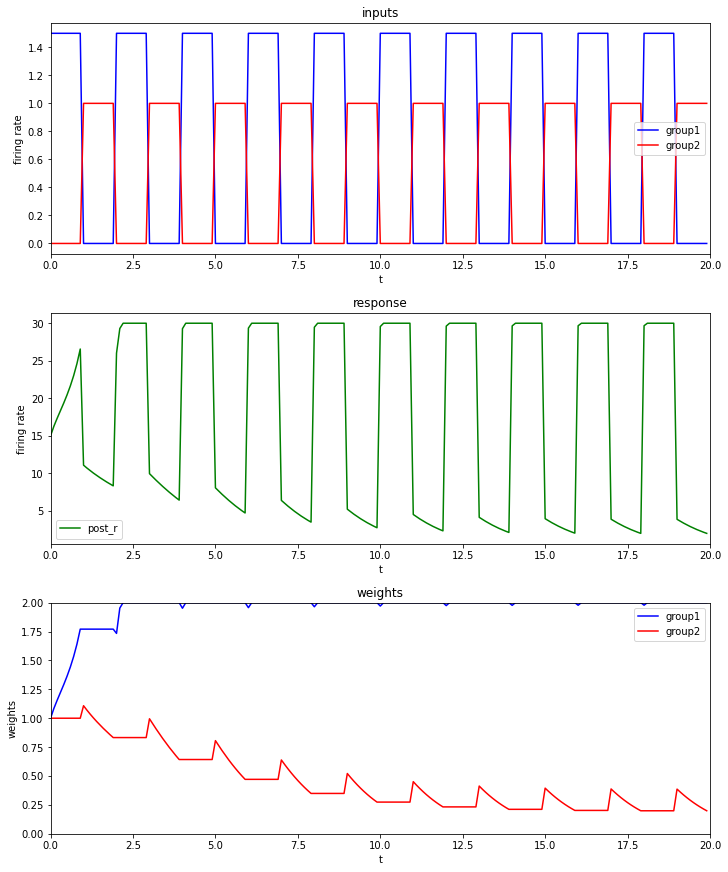

In [3]:
w_max = 2.
w = 1.
group1_rate = 1.5
group2_rate = 1.

neuron = rate_neuron()
post = bp.NeuGroup(neuron, 1, monitors=['r'])
pre = bp.NeuGroup(neuron, 20, monitors=['r'])

bcm_type = get_BCM(learning_rate=0.005, w_max=w_max, mode='vector')
bcm = bp.SynConn(model=bcm_type, pre_group=pre, post_group=post,
                    conn=bp.connect.All2All(), 
                    monitors=['w', 'dwdt'],
                    delay = 0.1)
bcm.r_th = np.zeros(post.size)
bcm.post_r = np.zeros(post.size)
bcm.sum_post_r = np.zeros(post.size)

bcm.ST['w'] = w

net = bp.Network(pre, bcm, post)

half_duration = 20 // 2
group1, duration = bp.inputs.constant_current(([group1_rate, 1], [0, 1])*half_duration)
group2, duration = bp.inputs.constant_current(([0, 1], [group2_rate, 1])*half_duration)

input_r = np.vstack((
                    (group1,)*10, (group2,)*10
                    ))


net.run(duration, inputs=(pre, 'ST.r', input_r.T, "="), report=False)


fig, gs = bp.visualize.get_figure(3, 1, 4, 10)
fig.add_subplot(gs[2, 0], xlim=(0, duration), ylim=(0, w_max))
plt.plot(net.ts, bcm.mon.w[:,0], 'b', label='group1')
plt.plot(net.ts, bcm.mon.w[:,-1], 'r', label='group2')
plt.title("weights")
plt.ylabel("weights")
plt.xlabel("t")
plt.legend()

fig.add_subplot(gs[0, 0], xlim=(0, duration))
plt.plot(net.ts, pre.mon.r[:,0], 'b', label='group1')
plt.plot(net.ts, pre.mon.r[:,-1], 'r', label='group2')
plt.title("inputs")
plt.ylabel("firing rate")
plt.xlabel("t")
plt.legend()

fig.add_subplot(gs[1, 0], xlim=(0, duration))
plt.plot(net.ts, post.mon.r[:, 0], 'g', label='post_r')
plt.title("response")
plt.ylabel("firing rate")
plt.xlabel("t")
plt.legend()

plt.show()